In [1]:
%config InlineBackend.figure_format = "retina"

In [2]:
import jupyter_black

jupyter_black.load(lab=False)

In [3]:
from importlib import resources

from jax import grad, jit, vmap
import jax.numpy as jnp
import mols2grid
import numpy as np
import pymbar
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole

import timemachine

# Relative hydration free energy

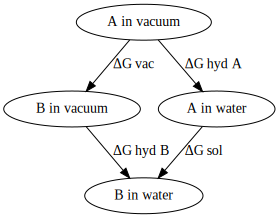

In [4]:
import graphviz

g = graphviz.Digraph()
g.node("A", label="A in vacuum")
g.node("B", label="B in vacuum")
g.node("AW", label="A in water")
g.node("BW", label="B in water")
g.edge("A", "B", label="<ΔG<SUB>vac</SUB>>")
g.edge("AW", "BW", label="<ΔG<SUB>sol</SUB>>")
g.edge("A", "AW", label="<ΔG<SUB>hyd A</SUB>>")
g.edge("B", "BW", label="<ΔG<SUB>hyd B</SUB>>")
g

\begin{equation}
0 = \Delta G_{\text{vac}} - \Delta G_{\text{sol}} - \Delta G_{\text{hyd A}} + \Delta G_{\text{hyd B}}
\end{equation}

\begin{equation}
\Delta \Delta G_{\text{hyd}} = \Delta G_{\text{hyd B}} - \Delta G_{\text{hyd A}} = \Delta G_{\text{sol}} - \Delta G_{\text{vac}}
\end{equation}

## Atom mapping

In [5]:
from timemachine.datasets import fetch_freesolv
from timemachine.fe import atom_mapping
from timemachine.fe.utils import get_mol_name, plot_atom_mapping_grid

In [6]:
mols = {get_mol_name(mol): mol for mol in fetch_freesolv()}

[09:28:00] Warning: molecule is tagged as 3D, but all Z coords are zero


In [7]:
mol_a = mols["mobley_3053621"]
mol_b = mols["mobley_3398536"]

In [8]:
mols2grid.display([mol_a, mol_b])

In [9]:
def compute_atom_mapping(threshold=2.0):
    assert mol_a.GetNumAtoms() == mol_b.GetNumAtoms()
    mcs_result = atom_mapping.mcs(mol_a, mol_b, threshold)
    query_mol = Chem.MolFromSmarts(mcs_result.smartsString)
    core = atom_mapping.get_core_by_mcs(mol_a, mol_b, query_mol, threshold)
    assert len(core) == mol_a.GetNumAtoms()
    return core, mcs_result.smartsString

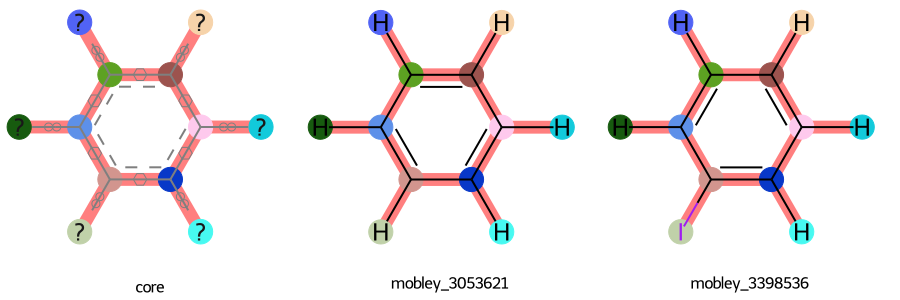

In [10]:
core, core_smarts = compute_atom_mapping()
plot_atom_mapping_grid(mol_a, mol_b, core_smarts, core)

## Vacuum leg

In [11]:
from timemachine.constants import DEFAULT_FF
from timemachine.fe.rbfe import estimate_relative_free_energy
from timemachine.ff import Forcefield

In [12]:
forcefield = Forcefield.load_from_file(DEFAULT_FF)

----------------------------------------------------------------------
performing BFGS minimization on 12 atoms
(holding the other 0 atoms frozen)
U(x_0) = 1843.214
         Current function value: 174.479223
         Iterations: 45
         Function evaluations: 135
         Gradient evaluations: 124
U(x_final) = 174.479
atom with highest force norm after minimization: 5
force(x_final)[5] = [ 0.71702435 -0.2382705   0.38456712]
----------------------------------------------------------------------
----------------------------------------------------------------------
performing BFGS minimization on 12 atoms
(holding the other 0 atoms frozen)
U(x_0) = 1743.584
         Current function value: 174.456425
         Iterations: 48
         Function evaluations: 216
         Gradient evaluations: 200
U(x_final) = 174.456
atom with highest force norm after minimization: 2
force(x_final)[2] = [-0.03836083  0.08853679 -0.00041229]
---------------------------------------------------------------

mobley_3053621_mobley_3398536_vacuum BAR: lambda 11 -> 12 dG: -0.142 +- 0.110 kJ/mol
----------------------------------------------------------------------
performing BFGS minimization on 12 atoms
(holding the other 0 atoms frozen)
U(x_0) = 707.340
         Current function value: 174.260834
         Iterations: 45
         Function evaluations: 135
         Gradient evaluations: 125
U(x_final) = 174.261
atom with highest force norm after minimization: 1
force(x_final)[1] = [-0.34545967  1.14795323  0.07459108]
----------------------------------------------------------------------
mobley_3053621_mobley_3398536_vacuum BAR: lambda 12 -> 13 dG: -0.073 +- 0.173 kJ/mol
----------------------------------------------------------------------
performing BFGS minimization on 12 atoms
(holding the other 0 atoms frozen)
U(x_0) = 511.466
         Current function value: 174.236982
         Iterations: 44
         Function evaluations: 183
         Gradient evaluations: 163
U(x_final) = 174.237
atom

mobley_3053621_mobley_3398536_vacuum BAR: lambda 24 -> 25 dG: -0.046 +- 0.015 kJ/mol
----------------------------------------------------------------------
performing BFGS minimization on 12 atoms
(holding the other 0 atoms frozen)
U(x_0) = 175.960
         Current function value: 174.061364
         Iterations: 14
         Function evaluations: 111
         Gradient evaluations: 102
U(x_final) = 174.061
atom with highest force norm after minimization: 0
force(x_final)[0] = [126.60752699 117.0945778    7.86753939]
----------------------------------------------------------------------
mobley_3053621_mobley_3398536_vacuum BAR: lambda 25 -> 26 dG: -0.037 +- 0.015 kJ/mol
----------------------------------------------------------------------
performing BFGS minimization on 12 atoms
(holding the other 0 atoms frozen)
U(x_0) = 177.553
         Current function value: 173.917255
         Iterations: 41
         Function evaluations: 236
         Gradient evaluations: 216
U(x_final) = 173.917
a

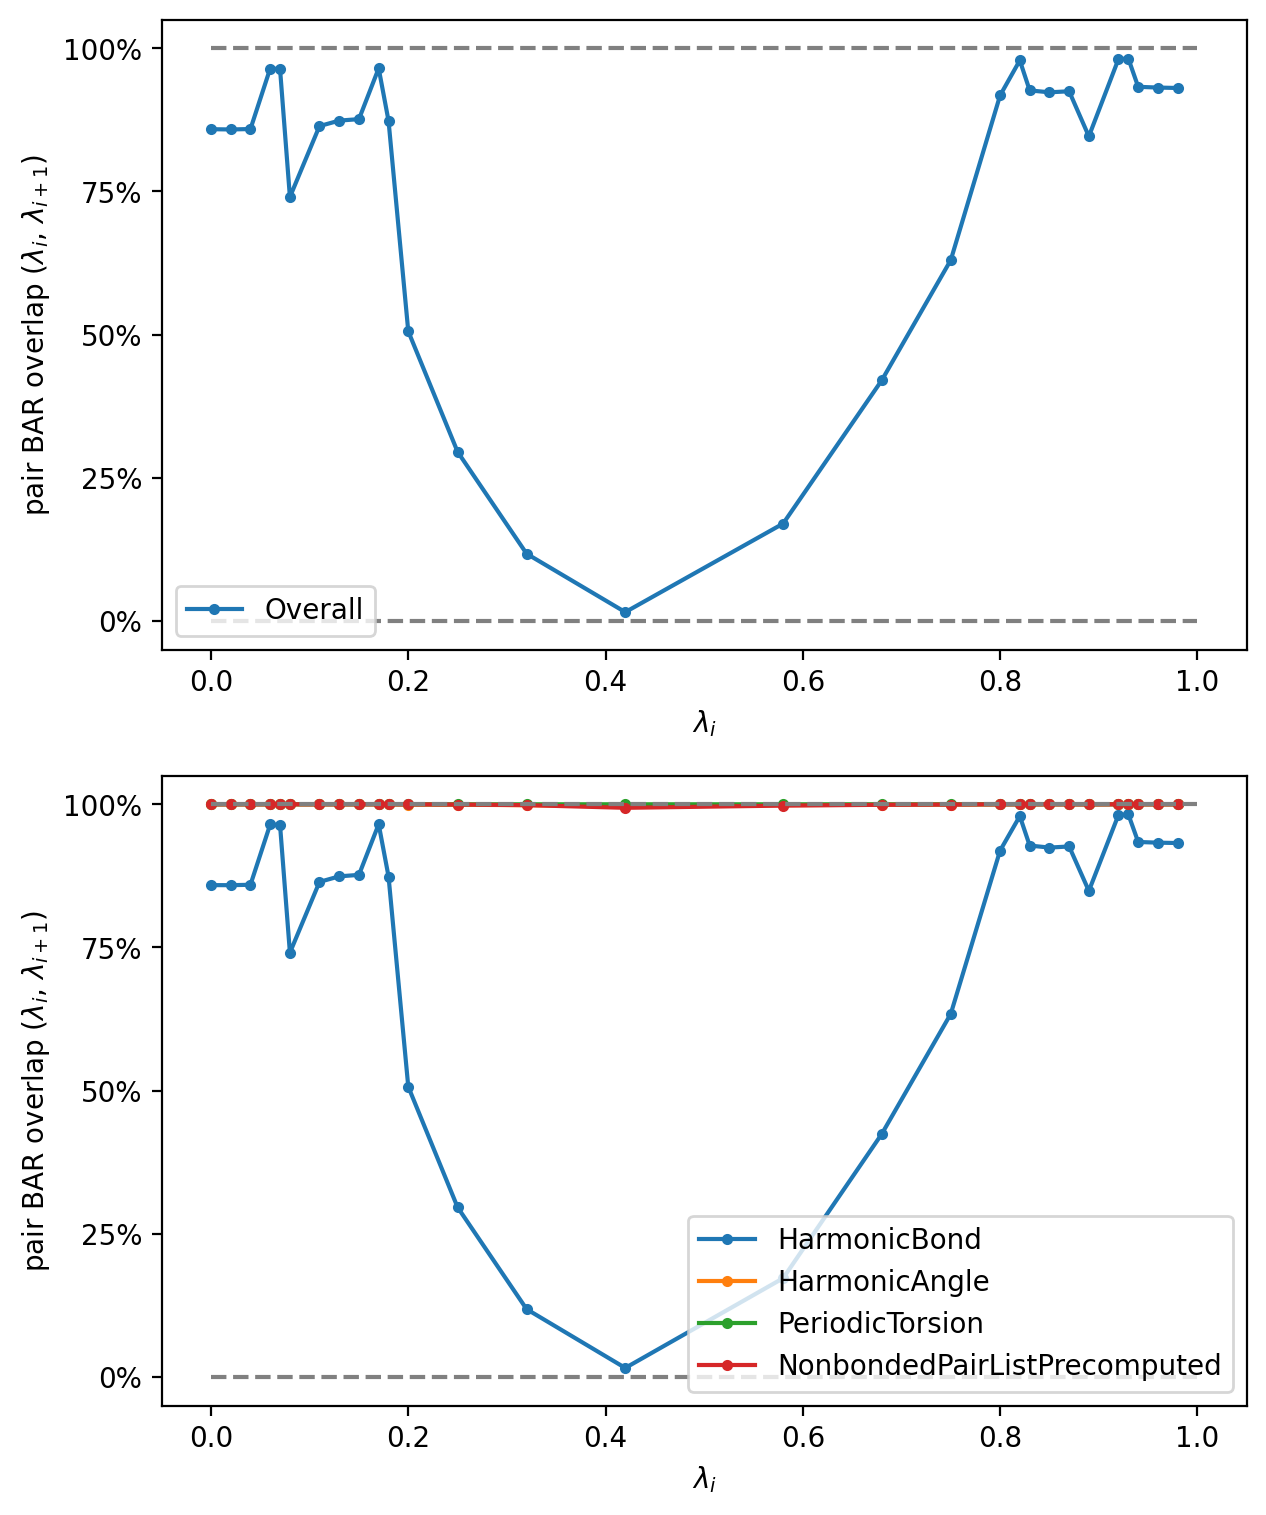

In [13]:
%%time
vacuum_res = estimate_relative_free_energy(
    mol_a,
    mol_b,
    core,
    forcefield,
    host_config=None,
    seed=123,
    n_frames=1000,
    prefix="vacuum",
    n_eq_steps=10000,
)

In [14]:
from timemachine.constants import KCAL_TO_KJ

In [15]:
vacuum_dG = np.array(vacuum_res.all_dGs).sum() / KCAL_TO_KJ
vacuum_dG_err = np.linalg.norm(vacuum_res.all_errs) / KCAL_TO_KJ
vacuum_dG, vacuum_dG_err

(-0.9265177782898046, 0.20860837578538588)

## Solvent leg

In [16]:
from timemachine.constants import DEFAULT_WATER_FF
from timemachine.fe.rbfe import HostConfig
from timemachine.md.builders import build_water_system

----------------------------------------------------------------------
performing BFGS minimization on 124 atoms
(holding the other 6170 atoms frozen)
U(x_0) = -102548.591
         Current function value: -104253.785256
         Iterations: 57
         Function evaluations: 140
         Gradient evaluations: 132
U(x_final) = -104253.785
atom with highest force norm after minimization: 6287
force(x_final)[6287] = [-1825.80884023  -330.95194923    56.22548274]
----------------------------------------------------------------------
----------------------------------------------------------------------
performing BFGS minimization on 124 atoms
(holding the other 6170 atoms frozen)
U(x_0) = -102648.282
         Current function value: -104256.254328
         Iterations: 52
         Function evaluations: 127
         Gradient evaluations: 122
U(x_final) = -104256.254
atom with highest force norm after minimization: 6287
force(x_final)[6287] = [-1761.57143831   -76.09339255    89.61656039]
---

         Current function value: -104248.511190
         Iterations: 36
         Function evaluations: 117
         Gradient evaluations: 109
U(x_final) = -104248.511
atom with highest force norm after minimization: 6284
force(x_final)[6284] = [2927.64486091  577.38149027   62.79947514]
----------------------------------------------------------------------
mobley_3053621_mobley_3398536_solvent BAR: lambda 11 -> 12 dG: 0.239 +- 0.114 kJ/mol
----------------------------------------------------------------------
performing BFGS minimization on 124 atoms
(holding the other 6170 atoms frozen)
U(x_0) = -103686.429
         Current function value: -104236.289508
         Iterations: 71
         Function evaluations: 203
         Gradient evaluations: 196
U(x_final) = -104236.290
atom with highest force norm after minimization: 6284
force(x_final)[6284] = [5640.49627144  152.40604318 -141.94435863]
----------------------------------------------------------------------
mobley_3053621_mobley_339

         Current function value: -104269.345656
         Iterations: 28
         Function evaluations: 88
         Gradient evaluations: 82
U(x_final) = -104269.346
atom with highest force norm after minimization: 1878
force(x_final)[1878] = [ 563.43678207 -534.33075938  250.37851298]
----------------------------------------------------------------------
mobley_3053621_mobley_3398536_solvent BAR: lambda 23 -> 24 dG: -0.209 +- 0.049 kJ/mol
----------------------------------------------------------------------
performing BFGS minimization on 124 atoms
(holding the other 6170 atoms frozen)
U(x_0) = -104226.393
         Current function value: -104269.180913
         Iterations: 30
         Function evaluations: 155
         Gradient evaluations: 146
U(x_final) = -104269.181
atom with highest force norm after minimization: 6282
force(x_final)[6282] = [-872.33918508  560.93035865  103.4394688 ]
----------------------------------------------------------------------
mobley_3053621_mobley_3398

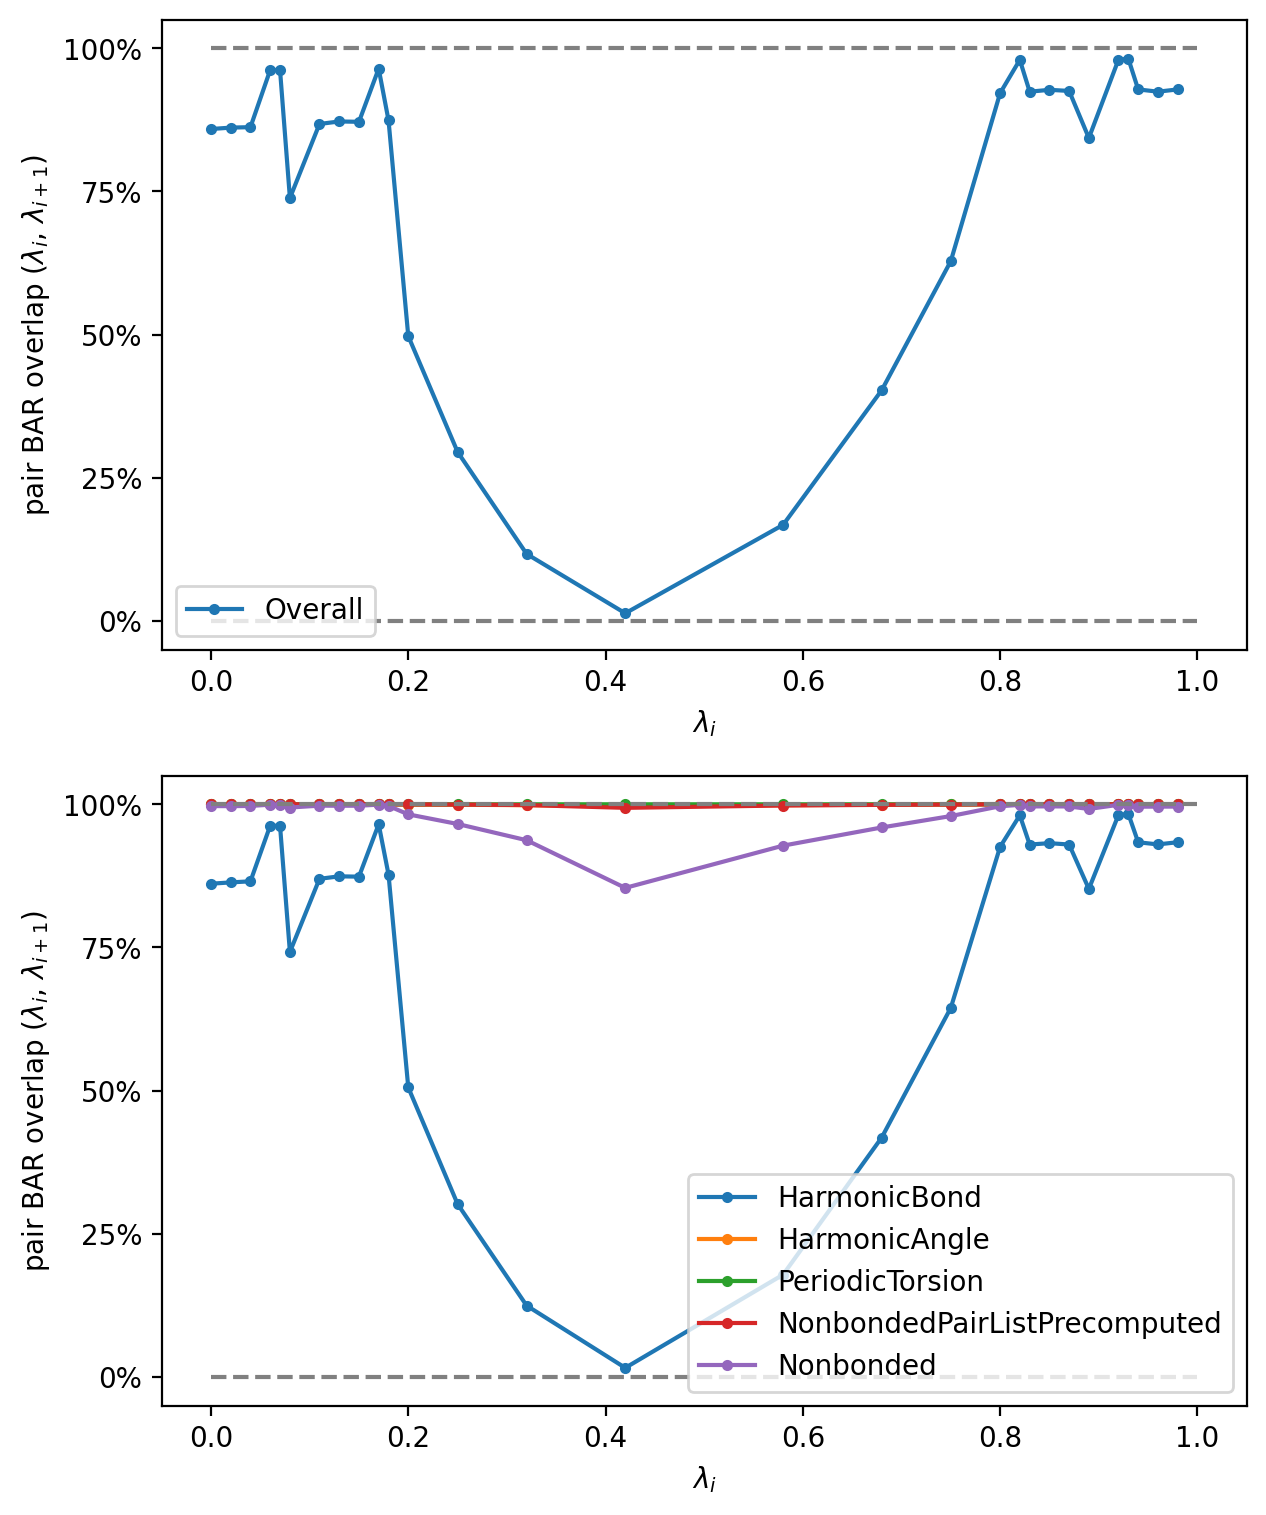

In [17]:
%%time
solvent_sys, solvent_conf, solvent_box, solvent_top = build_water_system(
    box_width=4.0, water_ff=DEFAULT_WATER_FF
)
solvent_box += np.diag([0.1, 0.1, 0.1])  # remove any possible clashes
solvent_host_config = HostConfig(solvent_sys, solvent_conf, solvent_box)

solvent_res = estimate_relative_free_energy(
    mol_a,
    mol_b,
    core,
    forcefield,
    solvent_host_config,
    seed=123,
    n_frames=1000,
    prefix="solvent",
    n_eq_steps=10000,
)

In [18]:
solvent_dG = np.array(solvent_res.all_dGs).sum() / KCAL_TO_KJ
solvent_dG_err = np.linalg.norm(solvent_res.all_errs) / KCAL_TO_KJ
solvent_dG, solvent_dG_err

(0.275690886438973, 0.21885514457098232)

## $\Delta \Delta G_{\text{hyd}}$

In [19]:
ddG = solvent_dG - vacuum_dG
ddG_err = np.linalg.norm([solvent_dG_err, vacuum_dG_err])
ddG, ddG_err

(1.2022086647287775, 0.3023491834832738)